In [1]:
import pandas as pd
import nltk


nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words("spanish")


def clean_label(label: str, invalid_chars: list[str], rep="") -> str:
    for c in invalid_chars:
        label = label.replace(c, rep)
    return ' '.join([word for word in label.split(' ') if word not in stopword_list])

invalid_chars = ['\n', ',', '.', '"', '-', '?', '!', '¿', '¡', '_']


labels = pd.read_csv('../data/labels.csv')[['id', 'label', 'duration']]
labels['label'] = labels['label'].apply(lambda x: clean_label(x, invalid_chars))
display(labels.head())
print(f"Clips: {labels['id'].count()}")
print(f"Total time: {labels['duration'].sum() / 60 / 60}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdalbianco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,label,duration
0,noticias-en-lengua-de-senas-argentina-resumen-...,dejar camino inglés país puño apretado gritand...,9.698
1,noticias-en-lengua-de-senas-argentina-resumen-...,mientras trabajábamos brindarte toda informac...,26.420
2,noticias-en-lengua-de-senas-argentina-resumen-...,recordado siempre programa homenaje persona,6.360
3,noticias-en-lengua-de-senas-argentina-resumen-...,buenas noches bienvenidos cn sordos argentina...,4.730
4,noticias-en-lengua-de-senas-argentina-resumen-...,nombre lucía,1.910


Clips: 8459
Total time: 22.006578611111117


In [2]:
from collections import Counter


def get_counter(labels: pd.DataFrame) -> (Counter, pd.DataFrame):
	total_words = [word for label in labels['label'] for word in label.split(' ')]
	words_freq = Counter(total_words)

	words_freq_df = pd.DataFrame([(w, f) for w, f in words_freq.items()], columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
	return words_freq, words_freq_df

## Word frequency

In [3]:
words, words_df = get_counter(labels)
words_df.tail(20)

,word,frequency
8915,acuerda,1
3662,entrerriana,1
8913,narrado,1
8912,haberla,1
8911,anécdota,1
8910,preguntan,1
3663,estandarte,1
3666,transformándose,1
8907,olvida,1
3667,sofisticado,1


,frequency
count,14037.000000
mean,5.047945
std,16.211982
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
90%,9.000000
95%,18.000000
99%,60.000000


array([[<Axes: title={'center': 'frequency'}>]], dtype=object)

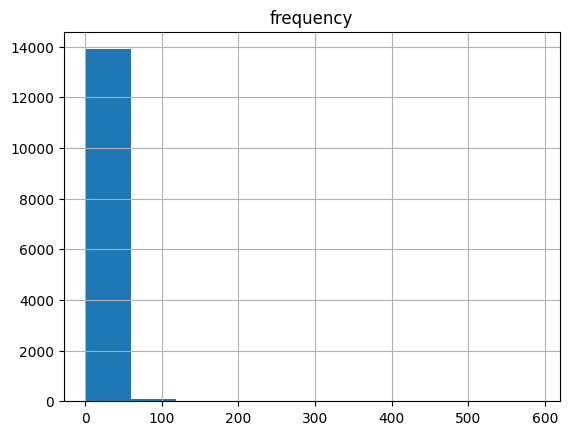

In [4]:
display(words_df.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
display(words_df.hist())

<Axes: xlabel='Word frequency', ylabel='Percentage'>

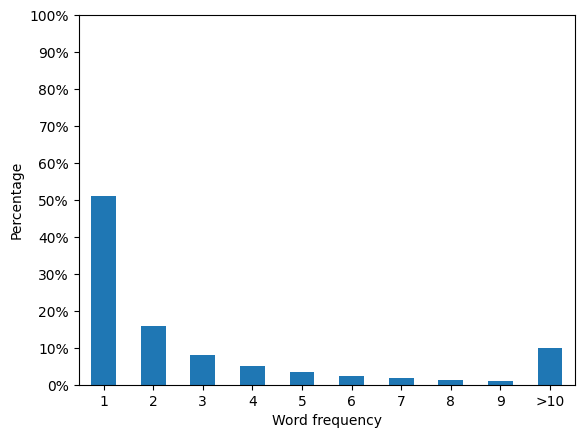

In [5]:
def simple_hist(words_df: pd.DataFrame) -> None:
	words_df_simple = words_df.copy()
	words_df_simple['frequency'] = [f if f < 10 else 10 for f in words_df_simple['frequency']]
	counts = words_df_simple['frequency'].value_counts()
	counts = 100*counts/counts.sum()
	for i in range(1, 11):
		if i not in counts.index:
			counts[i] = 0
	counts.sort_index(inplace=True)
	plot = counts.plot.bar(rot=0, xlabel="Word frequency", ylabel="Percentage")
	plot.set_yticks(range(0, 110, 10))
	plot.set_yticklabels([f"{i}%" for i in range(0, 110, 10)])
	plot.set_xticklabels([f"{i}" if i != 10 else ">10" for i in counts.index])
	display(plot)

simple_hist(words_df)

## Only using labels that appear more than once

In [6]:
mto = labels['label'].value_counts()[labels['label'].value_counts() > 1]
mto.describe()

count    321.000000
mean       2.781931
std        1.815502
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       21.000000
Name: count, dtype: float64

In [7]:
mto.head(200)

label
                                                      21
así                                                   12
interesante                                           11
 chau                                                 10
hola cómo nombre lucía                                 9
                                                      ..
dale                                                   2
personas sordas patagonia                              2
tres puntos tener cuenta                               2
quedan muestro sepan                                   2
comienza proceso disminuyeron ahora mandan bodegas     2
Name: count, Length: 200, dtype: int64

In [8]:
labels_mto = labels[labels['label'].isin(mto.index)]
display(labels_mto.head())
print(f"Clips: {labels_mto['id'].count()}")
print(f"Total time: {labels_mto['duration'].sum() / 60 / 60}")

,id,label,duration
4,noticias-en-lengua-de-senas-argentina-resumen-...,nombre lucía,1.91
39,noticias-en-lengua-de-senas-argentina-resumen-...,difícil,1.00
52,noticias-en-lengua-de-senas-argentina-resumen-...,vemos chau,2.09
166,noticias-en-lengua-de-senas-argentina-lsa-resu...,bienvenidos cómo bien,2.94
168,noticias-en-lengua-de-senas-argentina-lsa-resu...,lautaro,1.57


Clips: 893
Total time: 1.3457308333333349


,frequency
count,910.000000
mean,4.776923
std,6.824027
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
90%,9.000000
95%,17.000000
99%,35.640000


array([[<Axes: title={'center': 'frequency'}>]], dtype=object)

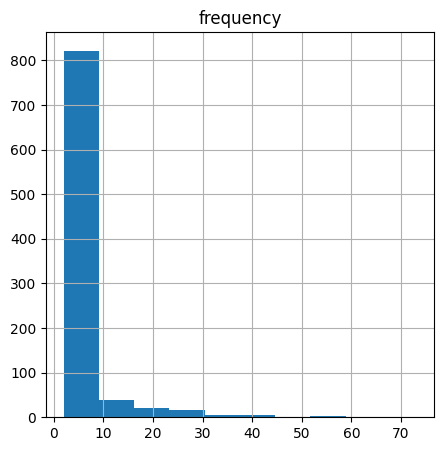

In [9]:
words_mto, words_mto_df = get_counter(labels_mto)
display(words_mto_df.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
display(words_mto_df.hist(figsize=(5, 5)))

<Axes: xlabel='Word frequency', ylabel='Percentage'>

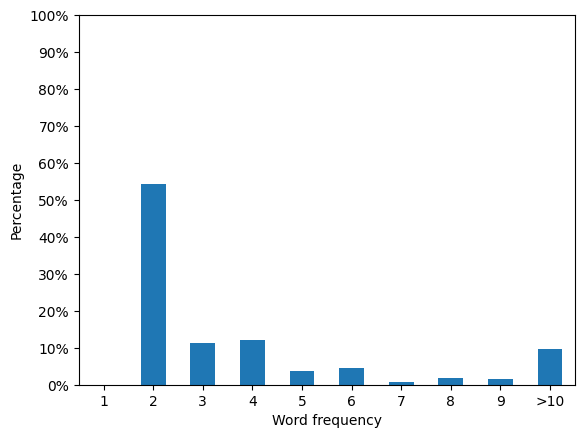

In [10]:
simple_hist(words_mto_df)

### Adding videos with words that only appear in previous set of words

In [11]:
labels_mto_plus = labels[labels['label'].apply(lambda x: all([word in words_mto.keys() or word in stopword_list for word in x.split(" ")]))]
display(labels_mto_plus.head())
print(f"Clips: {labels_mto_plus['id'].count()}")
print(f"Total time: {labels_mto_plus['duration'].sum() / 60 / 60}")

,id,label,duration
4,noticias-en-lengua-de-senas-argentina-resumen-...,nombre lucía,1.91
14,noticias-en-lengua-de-senas-argentina-resumen-...,hola,2.85
39,noticias-en-lengua-de-senas-argentina-resumen-...,difícil,1.00
47,noticias-en-lengua-de-senas-argentina-resumen-...,veremos pasa diciembre,1.73
52,noticias-en-lengua-de-senas-argentina-resumen-...,vemos chau,2.09


Clips: 1246
Total time: 1.7248333333333352


In [12]:
labels_mto_plus["label"].nunique()

674

,frequency
count,910.000000
mean,6.340659
std,10.597050
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
90%,12.000000
95%,22.000000
99%,59.460000


array([[<Axes: title={'center': 'frequency'}>]], dtype=object)

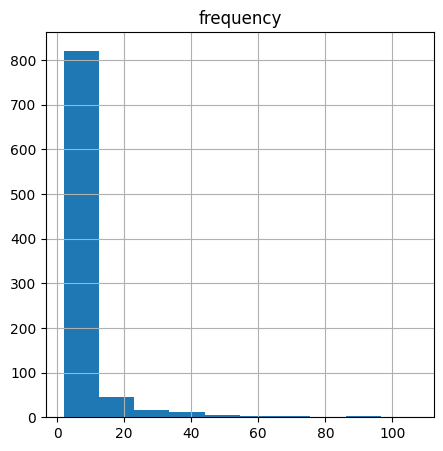

In [13]:
words_mto_plus, words_mto_plus_df = get_counter(labels_mto_plus)
display(words_mto_plus_df.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
display(words_mto_plus_df.hist(figsize=(5, 5)))

<Axes: xlabel='Word frequency', ylabel='Percentage'>

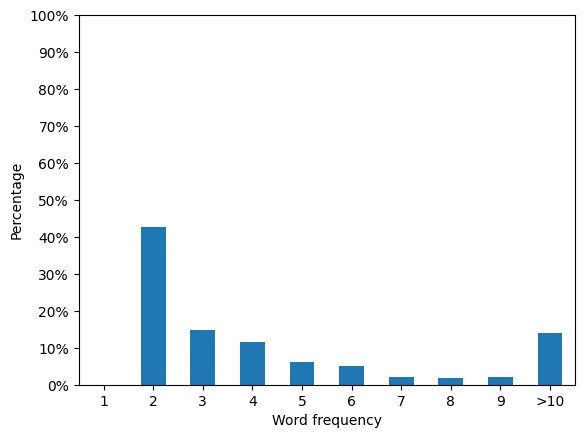

In [14]:
simple_hist(words_mto_plus_df)

In [15]:
labels_mto_plus["id"].to_csv("../data/labels_mto_plus.csv", index=False)

## Discarding those that contain words with frequency lower than threshold

In [14]:
labels['frequency'] = labels['label'].apply(lambda x: list(filter(lambda f: f>0, map(lambda w: words[w], x.split(" ")))))
labels.head()

,id,label,duration,frequency
0,noticias-en-lengua-de-senas-argentina-resumen-...,dejar camino inglés país puño apretado gritand...,9.698,"[21, 16, 13, 113, 1, 1, 2, 381, 381, 34]"
1,noticias-en-lengua-de-senas-argentina-resumen-...,mientras trabajábamos brindarte toda informac...,26.420,"[102, 43, 3, 1, 96, 114, 114, 70, 3, 13, 8, 1,..."
2,noticias-en-lengua-de-senas-argentina-resumen-...,recordado siempre programa homenaje persona,6.360,"[1, 135, 70, 7, 145]"
3,noticias-en-lengua-de-senas-argentina-resumen-...,buenas noches bienvenidos cn sordos argentina...,4.730,"[102, 5, 2, 62, 223, 434, 381, 114, 47, 381, 3..."
4,noticias-en-lengua-de-senas-argentina-resumen-...,nombre lucía,1.910,"[135, 57]"


In [15]:
labels_threshold = labels[labels['frequency'].apply(lambda x: min(x) > 1 if len(x) > 0 else False)]
display(labels_threshold.head())
print(f"Clips: {labels_threshold['id'].count()}")
print(f"Total time: {labels_threshold['duration'].sum() / 60 / 60}")

,id,label,duration,frequency
3,noticias-en-lengua-de-senas-argentina-resumen-...,buenas noches bienvenidos cn sordos argentina...,4.73,"[102, 5, 2, 62, 223, 434, 381, 114, 47, 381, 3..."
4,noticias-en-lengua-de-senas-argentina-resumen-...,nombre lucía,1.91,"[135, 57]"
5,noticias-en-lengua-de-senas-argentina-resumen-...,votan martes,2.03,"[2, 32]"
6,noticias-en-lengua-de-senas-argentina-resumen-...,avances investigaciones vacunas coronavirus,4.76,"[9, 5, 70, 89]"
7,noticias-en-lengua-de-senas-argentina-resumen-...,cuáles novedades auh,3.18,"[19, 20, 3]"


Clips: 4757
Total time: 8.919238333333334


,frequency
count,5214.000000
mean,5.671845
std,14.308161
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
90%,11.000000
95%,19.000000
99%,65.870000


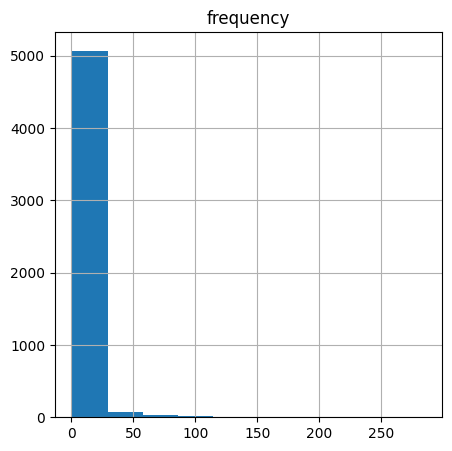

In [16]:
words_threshold, words_threshold_df = get_counter(labels_threshold)
display(words_threshold_df.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
words_hist_fig = words_threshold_df.hist(figsize=(5, 5))

<Axes: xlabel='Word frequency', ylabel='Percentage'>

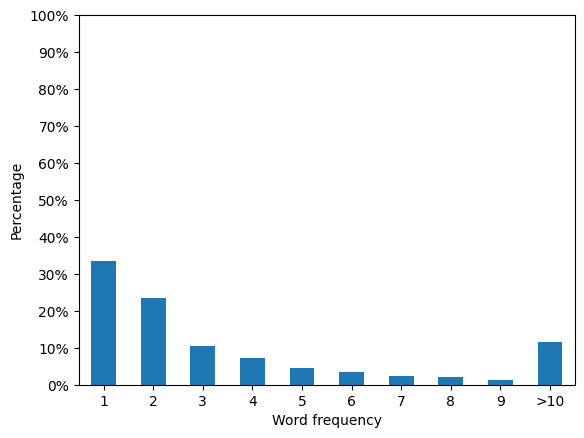

In [17]:
simple_hist(words_threshold_df)

## Considering mean/median frequency

In [18]:
from statistics import mean


labels_mean_fr_threshold = labels[labels['frequency'].apply(lambda x: mean(x) > 130 if len(x) > 0 else False)]
display(labels_mean_fr_threshold.head())
print(f"Clips: {labels_mean_fr_threshold['id'].count()}")
print(f"Total time: {labels_mean_fr_threshold['duration'].sum() / 60 / 60}")

,id,label,duration,frequency
3,noticias-en-lengua-de-senas-argentina-resumen-...,buenas noches bienvenidos cn sordos argentina...,4.73,"[102, 5, 2, 62, 223, 434, 381, 114, 47, 381, 3..."
14,noticias-en-lengua-de-senas-argentina-resumen-...,hola,2.85,"[102, 182]"
25,noticias-en-lengua-de-senas-argentina-resumen-...,incertidumbre si persona coronavirus si rescat...,5.90,"[2, 365, 145, 89, 365, 1, 228, 1]"
41,noticias-en-lengua-de-senas-argentina-resumen-...,cómo cambió veremos cómo va próximos días,4.49,"[356, 5, 14, 356, 116, 17, 116]"
45,noticias-en-lengua-de-senas-argentina-resumen-...,cómo protocolo lugar público,1.37,"[356, 28, 112, 35]"


Clips: 772
Total time: 1.1393758333333335


,frequency
count,1113.000000
mean,3.908356
std,14.549798
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
90%,5.000000
95%,10.400000
99%,66.000000


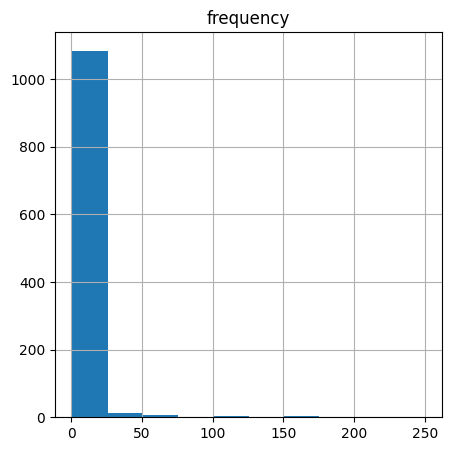

In [19]:
words_mean_fr_threshold_freq, words_mean_fr_threshold_freq_df = get_counter(labels_mean_fr_threshold)
display(words_mean_fr_threshold_freq_df.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
words_hist_fig = words_mean_fr_threshold_freq_df.hist(figsize=(5, 5))

<Axes: xlabel='Word frequency', ylabel='Percentage'>

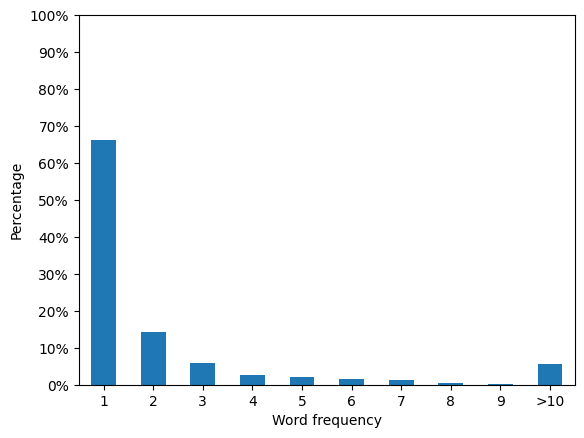

In [20]:
simple_hist(words_mean_fr_threshold_freq_df)